<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [1]:
#| default_exp svm.kernel_hpo

In [2]:
#|hide
# autoreload
%load_ext autoreload
%autoreload 2
from thu_big_data_ml.help import plt

本文档是上文绪论的后续

In [3]:
%load_ext rich

In [4]:
#| exports
from scholarly_infrastructure.logging.nucleus import logger, print
from sklearn.datasets import load_digits, fetch_openml
from thu_big_data_ml.svm.infra import process_sklearn_dataset_dict, compute_classification_metrics

In [5]:
#| exports
dataset_dict_uci_digits = load_digits(as_frame=False)
X_train, X_val, X_test, y_train, y_val, y_test, train_set, val_set, test_set, data_module, categories = process_sklearn_dataset_dict(dataset_dict_uci_digits, 'all')
dataset_dict_full_mnist = fetch_openml("mnist_784", as_frame=True)
X_train_full, X_val_full, X_test_full, y_train_full, y_val_full, y_test_full, train_set_full, val_set_full, test_set_full, data_module_full, categories_full = process_sklearn_dataset_dict(dataset_dict_full_mnist, 'all')

(1797, 64) float32 (1797,) int64 [0 1 2 3 4 5 6 7 8 9]
1293 144 360
(70000, 784) float32 (70000,) int64 [0 1 2 3 4 5 6 7 8 9]
50400 5600 14000


### 附加题: 对比不同 kernel 方法下的 SVM 分类器 （对完整SVM进行调参）

这一题本质上是让我们以 kernel 的选择（也包括选择线性Kernel）作为目标元参数，其他参数作为冗余或固定元参数，进行调参实验，发现不同 kernel 方法下的 SVM 分类器的分类效果数值上的区别及其显著性，并且从可视化分析上也作出进一步解释。

为了让问题简单清晰，我们再这一节不用我们自己实现的SVM（我们刚才实现的Linear Soft Margin SGD SVM），而是直接使用成熟的经过检验的，刚才我们测试出来最快的 Thunder SVM 库（与sklearn接口兼容，速度更快，使用GPU）。这样我们就可以专注于调参优化问题本身，而不是关注具体实现细节。

#### 科学调参的原则与方法

我在上次Project作业KD树中详细描述了谷歌AI团队《深度学习调优指南》的思想，涉及到的概念包括目标元参数、冗余元参数和固定元参数，贝叶斯优化、演化计算、近似随机搜索，科学实验的控制变量法与调参实验设计中的探索与利用、调参结果的假设检验分析等。这里我们不再赘述，需要的话可以阅读[上次作业的文档](https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data/blob/main/notebooks/coding_projects/P1_KNN/kd_tree.ipynb)。

#### 搜索空间定义

我们使用dataclass，要求传入函数的参数是强类型，而且有一个随机概率分布，这样方便定义调参。这里用到我自己写的`scholarly_infrastructure`库的一个核心功能，对Python标准的dataclass进行了改进。

In [6]:
#| exports
from scholarly_infrastructure.rv_args.nucleus import RandomVariable, experiment_setting
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
from typing import Optional, Union

In [ ]:
#| exports
@experiment_setting
class SupportVectorClassifierConfig:
    # 惩罚系数 C
    C: float = ~RandomVariable(
        default=1.0,
        description="Regularization parameter. The strength of the regularization is inversely proportional to C.",
        distribution=FloatDistribution(1e-5, 1e2, log=True)
    )
    
    # 核函数类型
    kernel: str = ~RandomVariable(
        default="rbf",
        description="Kernel type to be used in the algorithm.",
        distribution=CategoricalDistribution(choices=["linear", "poly", "rbf", "sigmoid",
                                                      "precomputed"
                                                      ])
    )
    
    # 多项式核函数的度数
    degree: int = ~RandomVariable(
        default=3,
        description="Degree of the polynomial kernel function ('poly').",
        distribution=IntDistribution(1, 10, log=False)
    )
    
    # 核函数系数 gamma
    gamma: Union[str, float] = ~RandomVariable(
        default="scale",
        description="Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.",
        distribution=CategoricalDistribution(choices=["scale", "auto"])  # 可以添加浮点数分布视需求
    )
    
    # 核函数独立项 coef0
    coef0: float = ~RandomVariable(
        default=0.0,
        description="Independent term in kernel function. It is significant in 'poly' and 'sigmoid'.",
        distribution=FloatDistribution(0, 1)
    )
    
    # 收缩启发式算法
    shrinking: bool = ~RandomVariable(
        default=True,
        description="Whether to use the shrinking heuristic.",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 是否启用概率估计
    probability: bool = ~RandomVariable(
        default=False,
        description="Whether to enable probability estimates. Slows down fit when enabled.",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 停止准则的容差 tol
    tol: float = ~RandomVariable(
        default=1e-3,
        description="Tolerance for stopping criterion.",
        distribution=FloatDistribution(1e-6, 1e-1, log=True)
    )
    
    # 内核缓存的大小（MB）
    cache_size: float = ~RandomVariable(
        default=200,
        description="Specify the size of the kernel cache (in MB).",
        distribution=FloatDistribution(50, 500, log=False)
    )
    
    # 类别权重 class_weight
    class_weight: Optional[Union[dict, str]] = ~RandomVariable(
        default=None,
        description="Set C of class i to class_weight[i]*C or use 'balanced' to adjust weights inversely to class frequencies.",
        distribution=CategoricalDistribution(choices=[None, "balanced"])
    )
    
    # 是否启用详细输出
    verbose: bool = ~RandomVariable(
        default=False,
        description="Enable verbose output (may not work properly in a multithreaded context).",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 最大迭代次数
    max_iter: int = ~RandomVariable(
        default=-1,
        description="Hard limit on iterations within solver, or -1 for no limit.",
        distribution=IntDistribution(-1, 1000, log=False)
    )
    
    # 决策函数形状
    decision_function_shape: str = ~RandomVariable(
        default="ovr",
        description="Whether to return a one-vs-rest ('ovr') decision function or original one-vs-one ('ovo').",
        distribution=CategoricalDistribution(choices=["ovo", "ovr"])
    )
    
    # 是否打破决策函数平局
    break_ties: bool = ~RandomVariable(
        default=False,
        description="If True, break ties according to the confidence values of decision_function when decision_function_shape='ovr'.",
        distribution=CategoricalDistribution(choices=[True, False])
    )
    
    # 随机种子 random_state
    random_state: Optional[int] = ~RandomVariable(
        default=None,
        description="Controls random number generation for probability estimates. Ignored when probability=False.",
        distribution=IntDistribution(0, 100)  # 根据需求设置范围
    )

In [8]:
# show_dataframe_doc(SupportVectorClassifierConfig)[:1]
SupportVectorClassifierConfig.show_dataframe_doc()[:1]
# SupportVectorClassifierConfig.get_optuna_search_space(frozen_rvs={"verbose", "cache_size", "random_state"})

name             type default  \
0    C  <class 'float'>     1.0   

                                     default_factory  init  repr  hash  \
0  <dataclasses._MISSING_TYPE object at 0x7f17f06...  True  True  None   

   compare metadata                                            kw_only  \
0     True     None  <dataclasses._MISSING_TYPE object at 0x7f17f06...   

                                         description  \
0  Regularization parameter. The strength of the ...   

                                        distribution  
0  FloatDistribution(high=100.0, log=True, low=1e...

In [9]:
#| exports
from dataclasses import asdict

#### 定义目标函数

In [10]:
#| exports
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import KFold

def evaluate_svm(config:SupportVectorClassifierConfig, X_train, y_train,
                 trial:optuna.Trial = None, 
                 critical_metric="acc1_pred", num_of_repeated=5):
    # 使用k fold交叉验证，相当于做了5次独立实验。
    kf = KFold(n_splits=num_of_repeated, shuffle=True, random_state=config.random_state)
    
    
    result_dict = dict()

    metric_names = set()
    
    # 进行5折交叉验证
    for experiment_index, (train_index, test_index) in enumerate(kf.split(X_train)):
        # 分割训练集和测试集
        X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        # 创建分类器实例
        model = SVC(**asdict(config))
        
        # 训练模型
        model.fit(X_train_fold, y_train_fold)
        
        # 预测测试集
        y_pred = model.predict(X_test_fold)
        
        # 计算准确率
        single_run_result = compute_classification_metrics(y_test_fold, y_pred=y_pred, labels=list(range(10)), y_pred_metrics_only=True)
        
        metric_names.update(single_run_result.keys())
        single_run_result = {f"{k}-run{experiment_index}":v for k, v in single_run_result.items()}
        result_dict|=single_run_result
        
        if trial is not None:
            for k, v in single_run_result.items():
                trial.set_user_attr(k, v)
            trial.report(single_run_result[f"{critical_metric}-run{experiment_index}"], experiment_index)
    for metric_name in metric_names:
        all_runs_results = [result_dict[f"{metric_name}-run{i}"] for i in range(num_of_repeated)]
        result_dict[f"{metric_name}-mean"] = sum(all_runs_results) / len(all_runs_results)
        if trial is not None:
            trial.set_user_attr(f"{metric_name}-mean", result_dict[f"{metric_name}-mean"])
    if trial is not None:
        trial.set_user_attr(f"num_of_repeated", num_of_repeated)
    return result_dict

In [11]:
#| exports
# 把 X_train 和 X_val 重新合并 
import numpy as np
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

In [12]:
evaluate_svm(SupportVectorClassifierConfig(kernel='linear'), X_train_val, y_train_val).keys()

dict_keys(['matthews_corrcoef-run0', 'f1-run0', 'precision-run0', 'recall-run0', 'balanced_accuracy-run0', 'cohen_kappa-run0', 'acc1_pred-run0', 'matthews_corrcoef-run1', 'f1-run1', 'precision-run1', 'recall-run1', 'balanced_accuracy-run1', 'cohen_kappa-run1', 'acc1_pred-run1', 'matthews_corrcoef-run2', 'f1-run2', 'precision-run2', 'recall-run2', 'balanced_accuracy-run2', 'cohen_kappa-run2', 'acc1_pred-run2', 'matthews_corrcoef-run3', 'f1-run3', 'precision-run3', 'recall-run3', 'balanced_accuracy-run3', 'cohen_kappa-run3', 'acc1_pred-run3', 'matthews_corrcoef-run4', 'f1-run4', 'precision-run4', 'recall-run4', 'balanced_accuracy-run4', 'cohen_kappa-run4', 'acc1_pred-run4', 'balanced_accuracy-mean', 'acc1_pred-mean', 'matthews_corrcoef-mean', 'cohen_kappa-mean', 'recall-mean', 'precision-mean', 'f1-mean'])

固定元参数定义

In [13]:
#| exports
fixed_meta_params = SupportVectorClassifierConfig(
    probability = False, # 暂时不研究，只关注 acc1_pred
    # 与性能无关
    cache_size  = 200, 
    verbose = False,
    random_state = 42, # 今天我们根据 K Fold 来做重复实验，不根据随机种子来做重复实验
)
frozen_rvs = {"probability", "cache_size", "verbose", "random_state"}

In [14]:
#| exports
def objective_svm(trial:optuna.Trial, critical_metric="acc1_pred", critical_reduction="mean"):
    config:SupportVectorClassifierConfig = SupportVectorClassifierConfig.optuna_suggest(
        trial, fixed_meta_params, frozen_rvs=frozen_rvs)
    try:
        cross_val_results = evaluate_svm(config, X_train_val, y_train_val, 
                                        trial=trial,
                                        critical_metric=critical_metric, num_of_repeated=5)
        critical_metric_name = f"{critical_metric}-{critical_reduction}"
        critical_result = cross_val_results[critical_metric_name]
    except ValueError as e:
        # logger.exception(e)
        logger.warning(f"Trial {trial.number} failed with error: {e}, we consider this as a pruned trial because it is because of the implicit constraints of the problem.")
        raise optuna.exceptions.TrialPruned()
    return critical_result

#### 执行调参搜索

In [15]:
#| exports
from thu_big_data_ml.help import runs_path
study_path = runs_path / "optuna_studies.db"
sqlite_url = f"sqlite:///{study_path}"

In [16]:
#| exports
from optuna.samplers import *
from optuna.pruners import *
import json
study = optuna.create_study(
    study_name="svm kernel hpo 11.17 3.0", 
    storage=sqlite_url, 
    load_if_exists=True, 
    sampler=QMCSampler(seed=42), # 谷歌建议
    pruner=WilcoxonPruner(), # 对重复实验进行假设检验剪枝
    direction="maximize")
study.set_user_attr("contributors", ["Ye Canming"])
study.set_user_attr("fixed_meta_parameters", json.dumps(asdict(fixed_meta_params)))

[I 2024-11-17 02:56:10,826] Using an existing study with name 'svm kernel hpo 11.17 3.0' instead of creating a new one.


In [ ]:
#| eval: false
# %%capture cap
study.optimize(objective_svm, n_trials=100)

In [43]:
study.optimize(objective_svm, n_trials=100)

[I 2024-11-17 03:23:48,679] Trial 102 finished with value: 0.9853827913279133 and parameters: {'C': 1.5392280037972343, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.5504842628983264, 'shrinking': True, 'tol': 0.0007587953406520845, 'class_weight': 'balanced', 'max_iter': 903, 'decision_function_shape': 'ovr', 'break_ties': True}. Best is trial 5 with value: 0.9902584204413472.
[I 2024-11-17 03:23:49,355] Trial 103 finished with value: 0.9853827913279133 and parameters: {'C': 2.0566717603631606, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.5550196498268634, 'shrinking': True, 'tol': 0.001055512867403289, 'class_weight': 'balanced', 'max_iter': 883, 'decision_function_shape': 'ovr', 'break_ties': True}. Best is trial 5 with value: 0.9902584204413472.
[I 2024-11-17 03:23:50,013] Trial 104 finished with value: 0.9853827913279133 and parameters: {'C': 1.4349574122957893, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'coef0': 0.5649013845116452, 'shrinking

In [19]:
#| hide
# with open('optuna.out.txt', 'w') as file:
#     file.write(cap.stdout)
# with open('optuna.err.txt', 'w') as file:
#     file.write(cap.stderr)

#### 分析实验结果

##### 最好的模型是哪个？

In [ ]:
study.best_params


{
    'C': 1.7782794100389216,
    'kernel': 'poly',
    'degree': 3,
    'gamma': 'auto',
    'coef0': 0.25,
    'shrinking': False,
    'tol': 1.7782794100389246e-05,
    'class_weight': None,
    'max_iter': 750,
    'decision_function_shape': 'ovo',
    'break_ties': False
}

In [55]:
study.best_value

0.9902584204413472

##### Optuna 可视化分析结果
可以通过下面的命令对我们刚才保存调参结果的数据库文件进行可视化展示：
```bash
optuna-dashboard sqlite:///optuna_studies.db --port 18081
```
<!-- ![alt text](image.png) -->
<img src=image.png width=60% />


我们也可以把这些图用代码画在本文档中

In [ ]:
study = optuna.load_study(
    study_name="svm kernel hpo 11.17 3.0", 
    storage=sqlite_url)

In [44]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [ ]:
plot_param_importances(study)

这个图非常有用，提示了我们元参数的重要性，这其实也是元参数的敏感性。如果目标值对某个参数过于敏感，那么它必须是冗余元参数，在其他变量变动的时候需要重新调参，而如果不是很敏感，我们就可以先固定它的值缩小搜索范围。

从图中可以看出，kernel是最重要的选择。

max_iter 很重要的话就意味着我们给的搜索空间max_iter可能还不够，有些方法潜在地需要更多的迭代次数才能收敛。在深度学习调参项目中，我们下一轮的实验迭代可能就要考虑修改搜索空间。这里我们只是做作业，所以暂时忽略。tol也很重要意味着其实我们tol可以给得更小，说明更小对优化精度是有用的。

网上的资料指出，C和gamma的选择对SVM的性能影响很大，然而在我们的200次实验观测中，可以看到gamma的影响并不是很大，至少在sklearn的两个自动选择gamma的方法来说，这两个自动选择都是合理的，可能网上的建议是说手动指定gamma的float会有很大影响。


In [45]:
plot_intermediate_values(study)

0-4是不同的K Fold下的结果。可以看出有些参数下不是那么稳定，特别是整体值比较差的的时候，随机波动也比较大。

In [46]:
plot_parallel_coordinate(study, params=["kernel", "C", "gamma"])

这个图其实我个人觉得意义不大，虽然很多调参软件都会有，看起来很炫酷，但是我觉得无法从图中读到什么有用的insight。因为好的值和坏的值图中交叉来交叉去，没法直接看出相关关系。

In [47]:
plot_contour(study, params=["C", 'tol', 'coef0'])

等高线图，看起来C比较大的时候颜色更深、

In [48]:
plot_slice(study)

这个图比较有用，可以看到每个随机变量不同值的影响。

In [53]:
plot_rank(study, params=['C', 'tol', 'kernel'])

##### 以 kernel 为目标元参数进行假设检验分析——期望改进分析


In [56]:
df = study.trials_dataframe()
df.head()

number     value             datetime_start          datetime_complete  \
0       0       NaN 2024-11-17 02:54:45.626373 2024-11-17 02:54:45.788622   
1       1       NaN 2024-11-17 02:55:18.722161 2024-11-17 02:55:18.797816   
2       2  0.956165 2024-11-17 02:56:10.992341 2024-11-17 02:56:11.578482   
3       3       NaN 2024-11-17 02:56:11.607921 2024-11-17 02:56:11.738309   
4       4  0.749492 2024-11-17 02:56:11.754529 2024-11-17 02:56:12.693953   

                duration  params_C params_break_ties params_class_weight  \
0 0 days 00:00:00.162249       NaN               NaN                 NaN   
1 0 days 00:00:00.075655       NaN               NaN                 NaN   
2 0 days 00:00:00.586141  0.004186              True                None   
3 0 days 00:00:00.130388  0.191854              True                None   
4 0 days 00:00:00.939424  0.031623             False                None   

   params_coef0 params_decision_function_shape  ...  \
0           NaN                            NaN  ...   
1           NaN                            NaN  ...   
2      0.708073                            ovr  ...   
3      0.000000                            ovr  ...   
4      0.500000                            ovr  ...   

   user_attrs_precision-run2 user_attrs_precision-run3  \
0                        NaN                       NaN   
1                        NaN                       NaN   
2                   0.961807                  0.957685   
3                        NaN                       NaN   
4                   0.839718                  0.859636   

  user_attrs_precision-run4  user_attrs_recall-mean user_attrs_recall-run0  \
0                       NaN                     NaN                    NaN   
1                       NaN                     NaN                    NaN   
2                  0.964761                0.956196               0.951926   
3                       NaN                     NaN                    NaN   
4                  0.849986                0.761556               0.733830   

   user_attrs_recall-run1  user_attrs_recall-run2  user_attrs_recall-run3  \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                     NaN   
2                0.954759                0.954058                0.958502   
3                     NaN                     NaN                     NaN   
4                0.775699                0.789870                0.766079   

   user_attrs_recall-run4     state  
0                     NaN      FAIL  
1                     NaN      FAIL  
2                0.961732  COMPLETE  
3                     NaN    PRUNED  
4                0.742302  COMPLETE  

[5 rows x 60 columns]

In [112]:
intersted_cols = [c for c in df.columns if c.startswith("params") or "user_attrs" in c or c=="value"]
# intersted_cols = [c for c in df.columns if c.startswith("params") or c=="value"]
dfi = df[intersted_cols].dropna(subset=[target])
dfi.head()

value   params_C params_break_ties params_class_weight  params_coef0  \
2  0.956165   0.004186              True                None      0.708073   
4  0.749492   0.031623             False                None      0.500000   
5  0.990258   1.778279             False                None      0.250000   
6  0.130139   0.000562             False            balanced      0.750000   
8  0.984688  13.335214             False            balanced      0.125000   

  params_decision_function_shape  params_degree params_gamma params_kernel  \
2                            ovr            1.0        scale        linear   
4                            ovr            5.0        scale           rbf   
5                            ovo            3.0         auto          poly   
6                            ovr            8.0        scale       sigmoid   
8                            ovo            9.0        scale        linear   

   params_max_iter  ... user_attrs_precision-run1  user_attrs_precision-run2  \
2            182.0  ...                  0.947915                   0.961807   
4            499.0  ...                  0.801343                   0.839718   
5            750.0  ...                  0.985863                   0.988889   
6            249.0  ...                  0.013542                   0.010105   
8            875.0  ...                  0.990013                   0.982012   

   user_attrs_precision-run3  user_attrs_precision-run4  \
2                   0.957685                   0.964761   
4                   0.859636                   0.849986   
5                   0.981481                   1.000000   
6                   0.010453                   0.038927   
8                   0.975091                   0.993521   

   user_attrs_recall-mean  user_attrs_recall-run0  user_attrs_recall-run1  \
2                0.956196                0.951926                0.954759   
4                0.761556                0.733830                0.775699   
5                0.989942                0.991154                0.986591   
6                0.120000                0.100000                0.100000   
8                0.984161                0.982063                0.988435   

   user_attrs_recall-run2  user_attrs_recall-run3  user_attrs_recall-run4  
2                0.954058                0.958502                0.961732  
4                0.789870                0.766079                0.742302  
5                0.989747                0.982219                1.000000  
6                0.100000                0.100000                0.200000  
8                0.981054                0.975855                0.993398  

[5 rows x 55 columns]

In [109]:
target = "value"
treatment = "params_kernel"

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='params_kernel', ylabel='value'>

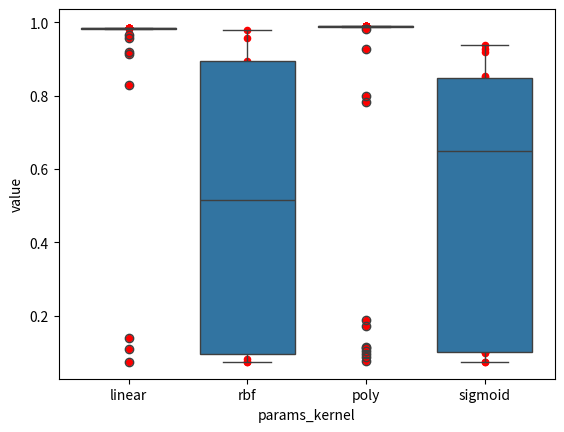

In [ ]:
#| fig-cap: "uniform与distance方法平均准确率箱线图对比"
#| fig-alt: "每一个红点是一次实验结果，平均准确率是每一次实验中五折交叉验证的平均值。"
fig, ax = plt.subplots()
sns.boxplot(data=dfi, x=treatment, y=target, ax=ax)
dfi.plot(x=treatment, y=target, ax=ax, kind='scatter', c='red')

从中可以看出, `linear`和 `poly` 平均值比较高，而且太集中了画不出图。
而 `rbf` 和 `sigmoid` 则是有很多结果比较低，平均值在中间。


除了箱线图，还可以画分布图，来展示不同kernel对精度的影响。

Text(22.89317438271604, 0.5, '频数')

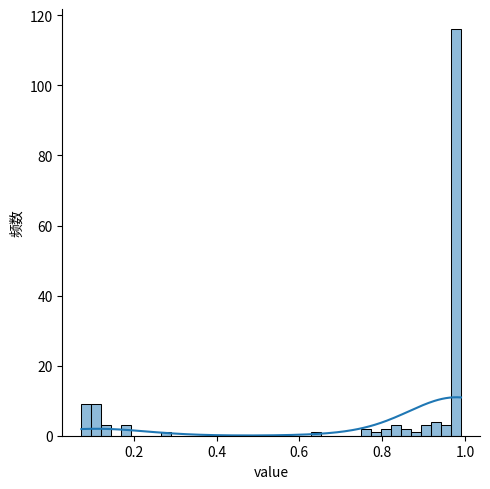

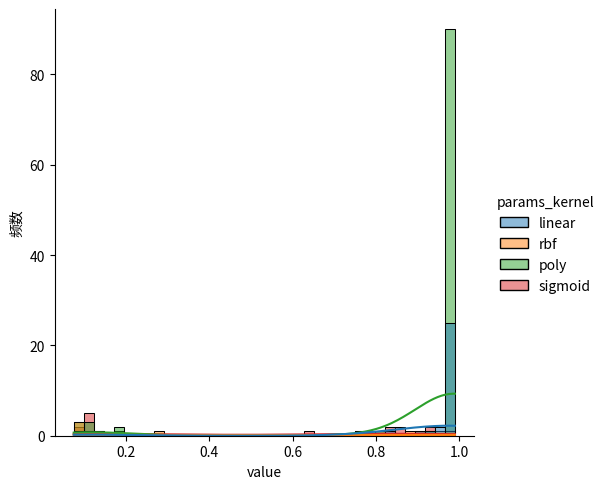

In [ ]:
sns.displot(data=dfi, x=target, kde=True, kind="hist")
plt.ylabel("频数")
sns.displot(data=dfi, x=target, hue=treatment, kde=True, kind="hist")
plt.ylabel("频数")

我们在同时比较多个方法，可以用ANOVA检验吗？
可以使用我之前写的代码，看看ANOVA的条件是否满足。

In [ ]:
from thu_big_data_ml.big_data_analytics.anova import test_normality_group, homogeneity_of_variance

In [ ]:
test_normality_group(dfi, interesting_col=target, hue_col=treatment)

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.



linear        poly         rbf     sigmoid
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal  Not Normal  Not Normal  Not Normal
D'Agostino-Pearson  Not Normal  Not Normal  Not Normal  Not Normal

In [ ]:
log_transform = lambda data_column: np.log(data_column+np.min(data_column)+1)  # 保证 大于0 
test_normality_group(dfi, interesting_col=target, hue_col=treatment, transform=log_transform)

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning:

`kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=19 observations were given.



linear        poly         rbf     sigmoid
Kolmogorov-Smirnov  Not Normal  Not Normal  Not Normal  Not Normal
Anderson-Darling    Not Normal  Not Normal  Not Normal  Not Normal
D'Agostino-Pearson  Not Normal  Not Normal  Not Normal  Not Normal

In [ ]:
homogeneity_of_variance(dfi, interesting_col=target, hue_col=treatment)

The variances may be homogeneous, according to rule of thumb.
Reject the null hypothesis of equal variances! 



{
    'ratio_largest_to_smallest': 1.7386168726213924,
    'bartlett_result': BartlettResult(statistic=12.750075189817064, pvalue=0.005209469719008144)
}

看来我们的数据并不服从正态分布，就算经过了log变换也不服从。
而且`bartlett`假设检验显著地发现方差齐性不满足，虽然经验法则说勉强可以接受<2的方差差异。

In [77]:
from thu_big_data_ml.big_data_analytics.anova import auto_anova_for_df, auto_kruskal_for_df

In [ ]:
auto_anova_for_df(dfi, interesting_col=target, hue_col=treatment)

Source  Sum of Squares (SS)  Degrees of Freedom (df)  Mean Square (MS)  \
0  Between             4.040434                        3          1.346811   
1   Within            11.818181                      159          0.074328   
2    Total            15.858614                      162               NaN   

           F             p       p_excel  
0  18.119793  3.648672e-10  4.007048e-10  
1        NaN           NaN           NaN  
2        NaN           NaN           NaN

尽管ANOVA的使用条件不满足，但是我们勉强使用ANOVA，可以看到ANOVA方法的p值很小，很显著地不同kernel之间存在显著差异！

接下来我们使用 Kruskal-Wallis 检验，这个检验不需要方差齐性和正态性满足，就可以对多列样本进行比较

In [ ]:
res = auto_kruskal_for_df(dfi, interesting_col=target, hue_col=treatment)
if res.pvalue < 0.05:
    print("There is a significant difference between the kernel functions.")
res

Sun 2024-11-17 04:01:46.595267

INFO     There is a significant difference between the kernel functions.                              ]8;id=855038;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=607441;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

KruskalResult(statistic=89.11831011539, pvalue=3.3878339514086004e-19)

Kruskal-Wallis H-test tests的零假设是 不同组的中位数之间没有显著差异。看来我们可以拒绝原假设，认为不同kernel的SVM的中位数有显著差异。

刚才我们检验出来存在显著差异，但是不知道具体是谁比谁大有显著性，所以我们还需要使用post-hoc类型的假设检验来进行进一步的分析。

首先刚才检验的是中位数有显著差异，我们来求一下分组的中位数。

In [ ]:
import pandas as pd
medians = df.groupby(treatment)[target].median().sort_values(ascending=False)
medians


params_kernel
poly           0.989559
linear         0.985383
sigmoid        0.650010
rbf            0.516373
precomputed         NaN
Name: value, dtype: float64

In [106]:
order = medians.index[:-1]


Dunn’s test就是针对 Kruskal-Wallis one-way analysis 对应的 post-hoc 检验方法（之一，还有其他的）。

In [100]:
#| exports
import scikit_posthocs as sp
from scikit_posthocs import posthoc_dunn

In [ ]:
res = posthoc_dunn(dfi, val_col=target, group_col=treatment, 
             sort=True, p_adjust='holm')

# 按照中位数大小排序
res = res.reindex(order)
res = res[order]
res

poly        linear       sigmoid           rbf
params_kernel                                                        
poly           1.000000e+00  3.388027e-08  1.939419e-12  2.481610e-07
linear         3.388027e-08  1.000000e+00  6.615530e-02  1.597734e-01
sigmoid        1.939419e-12  6.615530e-02  1.000000e+00  9.446169e-01
rbf            2.481610e-07  1.597734e-01  9.446169e-01  1.000000e+00

(<Axes: ylabel='params_kernel'>, <matplotlib.colorbar.Colorbar object at 0x7f1699ac9210>)

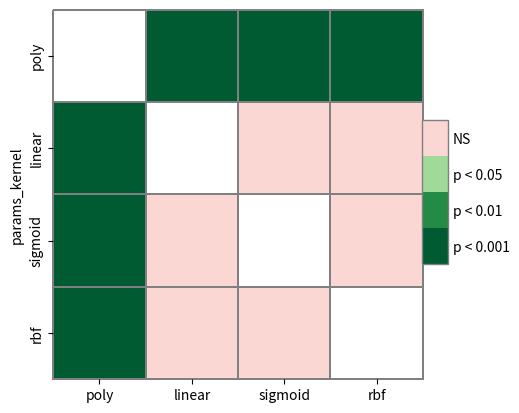

In [108]:
# res < 0.05
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(res, **heatmap_args)

从结果表可以看出，poly非常显著地优于其他三个方法，是最好的方法。而linear虽然看起来中位数比剩下两个方法高，但是不显著。

以上的结果似乎不符合读者的直觉，你可能会说“kernel method不是很厉害吗，SVM重要的方法之一哎，怎么会不行呢？” 

需要注意的是，我们刚才的实验随机采样了很多参数，kernel method也有厉害的参数，也有不厉害的参数。那我们刚才严格的假设检验如何解读呢？

正确的解读应该是这样的。假如有一个小白，不懂SVM，让他随机选择一个参数来调用sklearn库。我们是调过参的，我们告诉他，你是小白，如果你用rbf和sigmoid，你随便选别的参数，你很容易犯错误，让指标特别低。相反地，如果你用linear或者poly，你随便调其他的参数都无所谓，你大概率是能得到较好的结果的。

这就是我们上面的研究的意义，一个新的随机用户在随机场景下使用你的方法来替代其他方法时，他得到的期望改进。我们的结果就是 linear 和 poly的期望更高。但是这不意味着专家不能用rbf 和 sigmoid经过仔细调参得到更好的结果。

##### 以 kernel 为目标元参数进行假设检验分析——最优对比分析


In [113]:
max_rows = dfi.loc[dfi.groupby(treatment)[target].idxmax()]
max_rows

value   params_C params_break_ties params_class_weight  params_coef0  \
24  0.985383  60.429639              True            balanced      0.343750   
5   0.990258   1.778279             False                None      0.250000   
45  0.979820  77.736503             False            balanced      0.015625   
57  0.937369   0.835363             False            balanced      0.171875   

   params_decision_function_shape  params_degree params_gamma params_kernel  \
24                            ovr            6.0        scale        linear   
5                             ovo            3.0         auto          poly   
45                            ovo            4.0         auto           rbf   
57                            ovr            2.0        scale       sigmoid   

    params_max_iter  ... user_attrs_precision-run1  user_attrs_precision-run2  \
24            656.0  ...                  0.990013                   0.985716   
5             750.0  ...                  0.985863                   0.988889   
45            453.0  ...                  0.981515                   0.985716   
57            797.0  ...                  0.934272                   0.942155   

    user_attrs_precision-run3  user_attrs_precision-run4  \
24                   0.974978                   0.990491   
5                    0.981481                   1.000000   
45                   0.971346                   0.983036   
57                   0.938151                   0.939654   

    user_attrs_recall-mean  user_attrs_recall-run0  user_attrs_recall-run1  \
24                0.984965                0.985093                0.988435   
5                 0.989942                0.991154                0.986591   
45                0.979199                0.972401                0.983471   
57                0.936771                0.942251                0.931733   

    user_attrs_recall-run2  user_attrs_recall-run3  user_attrs_recall-run4  
24                0.984900                0.975855                0.990541  
5                 0.989747                0.982219                1.000000  
45                0.984758                0.971617                0.983750  
57                0.938035                0.936699                0.935135  

[4 rows x 55 columns]

In [114]:
critical_metric = "acc1_pred"
num_repeated = 5
kfold_metrics = [f"user_attrs_{critical_metric}-run{i}" for i in range(num_repeated)]

In [123]:
intereting_df =  max_rows[[treatment]+kfold_metrics]
intereting_df = intereting_df.set_index(treatment)
intereting_df

user_attrs_acc1_pred-run0  user_attrs_acc1_pred-run1  \
params_kernel                                                         
linear                          0.986111                   0.989583   
poly                            0.993056                   0.986111   
rbf                             0.975694                   0.982639   
sigmoid                         0.940972                   0.934028   

               user_attrs_acc1_pred-run2  user_attrs_acc1_pred-run3  \
params_kernel                                                         
linear                          0.986063                   0.975610   
poly                            0.989547                   0.982578   
rbf                             0.986063                   0.972125   
sigmoid                         0.940767                   0.937282   

               user_attrs_acc1_pred-run4  
params_kernel                             
linear                          0.989547  
poly                            1.000000  
rbf                             0.982578  
sigmoid                         0.933798

In [136]:
analysis_df = intereting_df.transpose()
analysis_df = analysis_df.reset_index(drop=False)
analysis_df = analysis_df.rename(columns={analysis_df.columns[0]: 'runs'})
analysis_df = analysis_df.rename_axis('index')
analysis_df

params_kernel                       runs    linear      poly       rbf  \
index                                                                    
0              user_attrs_acc1_pred-run0  0.986111  0.993056  0.975694   
1              user_attrs_acc1_pred-run1  0.989583  0.986111  0.982639   
2              user_attrs_acc1_pred-run2  0.986063  0.989547  0.986063   
3              user_attrs_acc1_pred-run3  0.975610  0.982578  0.972125   
4              user_attrs_acc1_pred-run4  0.989547  1.000000  0.982578   

params_kernel   sigmoid  
index                    
0              0.940972  
1              0.934028  
2              0.940767  
3              0.937282  
4              0.933798

In [138]:
array_data = analysis_df.drop(analysis_df.columns[0], axis=1).values
array_data


array([[0.98611111, 0.99305556, 0.97569444, 0.94097222],
       [0.98958333, 0.98611111, 0.98263889, 0.93402778],
       [0.98606272, 0.98954704, 0.98606272, 0.94076655],
       [0.97560976, 0.9825784 , 0.97212544, 0.93728223],
       [0.98954704, 1.        , 0.9825784 , 0.93379791]])

In [155]:
analysis_df.columns[1]

'linear'

In [156]:
from scikit_posthocs import __convert_to_block_df
analysis_df_regular, _, _, _ = __convert_to_block_df(array_data)
analysis_df_regular = analysis_df_regular.rename(columns={'blocks': 'runs', 
                                                          'groups': treatment, 'y':target})
analysis_df_regular[treatment] = analysis_df_regular[treatment].apply(lambda x: analysis_df.columns[1+x])
analysis_df_regular

runs params_kernel     value
0      0        linear  0.986111
1      1        linear  0.989583
2      2        linear  0.986063
3      3        linear  0.975610
4      4        linear  0.989547
5      0          poly  0.993056
6      1          poly  0.986111
7      2          poly  0.989547
8      3          poly  0.982578
9      4          poly  1.000000
10     0           rbf  0.975694
11     1           rbf  0.982639
12     2           rbf  0.986063
13     3           rbf  0.972125
14     4           rbf  0.982578
15     0       sigmoid  0.940972
16     1       sigmoid  0.934028
17     2       sigmoid  0.940767
18     3       sigmoid  0.937282
19     4       sigmoid  0.933798

现在我们对五折交叉验证的结果来对四个方法进行假设检验。
这一次我们该使用 Friedman 检验, 这也是一个不需要正态性和方差齐性的检验方法，某种程度上[论文](https://www.jmlr.org/papers/volume7/demsar06a/demsar06a.pdf)会选择这个而非 Kruskal-Wallis。
刚才我们不用是因为刚才每一组的样本量不一致，而 Friedman 检验要求样本量一致

In [141]:
import scipy.stats as ss
res = ss.friedmanchisquare(*array_data.T)
if res.pvalue < 0.05:
    print("Reject null hypothesis. Therefore, the data is significantly different.")
res

Sun 2024-11-17 05:00:03.244110

INFO     Reject null hypothesis. Therefore, the data is significantly different.                      ]8;id=449707;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py\nucleus.py]8;;\:]8;id=140023;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/nucleus.py#53\53]8;;\

FriedmanchisquareResult(statistic=13.653061224489791, pvalue=0.003417529443793913)

Nemenyi 是其中的一个 对应于 Friedman 的测试。

首先我们需要计算4个方法的平均排名（在同一个cv fold上，相互之间的排名），这个是 判断哪个方法更好的核心依据。

In [165]:
avg_rank = analysis_df_regular.groupby('runs').value.rank(pct=True).groupby(analysis_df_regular.params_kernel).mean().sort_values(ascending=False)
avg_rank


params_kernel
poly       0.950
linear     0.775
rbf        0.525
sigmoid    0.250
Name: value, dtype: float64

按照平均排名重新排序

In [167]:
analysis_df = analysis_df[avg_rank.index]
analysis_df

params_kernel      poly    linear       rbf   sigmoid
index                                                
0              0.993056  0.986111  0.975694  0.940972
1              0.986111  0.989583  0.982639  0.934028
2              0.989547  0.986063  0.986063  0.940767
3              0.982578  0.975610  0.972125  0.937282
4              1.000000  0.989547  0.982578  0.933798

In [169]:
array_data = analysis_df.values
array_data


array([[0.99305556, 0.98611111, 0.97569444, 0.94097222],
       [0.98611111, 0.98958333, 0.98263889, 0.93402778],
       [0.98954704, 0.98606272, 0.98606272, 0.94076655],
       [0.9825784 , 0.97560976, 0.97212544, 0.93728223],
       [1.        , 0.98954704, 0.9825784 , 0.93379791]])

In [170]:
import scikit_posthocs as sp
# res = sp.posthoc_nemenyi_friedman(analysis_df_regular, 
#                                   block_col="runs", 
#                                   group_col=treatment, y_col=target, sort=True)
res = sp.posthoc_nemenyi_friedman(array_data) 
res

0         1         2         3
0  1.000000  0.826788  0.158925  0.003389
1  0.826788  1.000000  0.611061  0.049612
2  0.158925  0.611061  1.000000  0.532733
3  0.003389  0.049612  0.532733  1.000000

(<Axes: >, <matplotlib.colorbar.Colorbar object at 0x7f1697928850>)

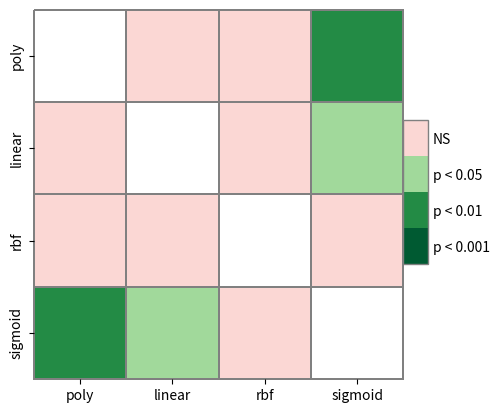

In [178]:
sp.sign_plot(res, xticklabels=avg_rank.index, yticklabels=avg_rank.index, **heatmap_args)

从检验的结果图可以看出，poly和linear方法明显优于sigmoid，而其他方法之间就没有足够的实验证据来进行比较。
这说明sigmoid方法即使调到了较优的超参数，还是显著比前两个方法要弱一些，不建议新手使用。

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scikit_posthocs/_plotting.py:509: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/scikit_posthocs/_plotting.py:529: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



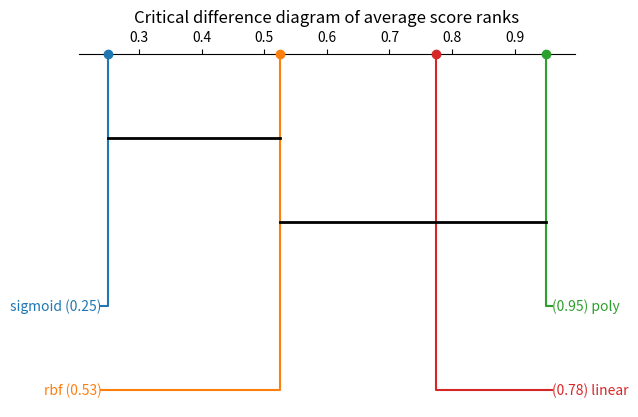

In [180]:
plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(avg_rank, res)
pass

我们还画出了 Critical difference diagram。 图中靠右边的方法平均排名高，左边的方法平均排名低。
排名的差距是否具有统计上的显著性，关键看差距是否大于图中的黑色实线的长度。

我们可以看到poly几乎就要显著优于rbf了，而rbf几乎就要显著优于sigmoid了，但是都还差一点不太显著。

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()